## Import Libraries

In [1]:
import os
import warnings

import scipy as sp
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import dateutil.relativedelta

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, roc_auc_score
from sklearn import metrics

import xgboost as xgb

from google.colab import drive

In [2]:
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
%matplotlib inline

In [3]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
RANDOM_STATE = 42

## Load Data

In [5]:
DATA_PATH = "gdrive/MyDrive/EASY_MONEY_NUCLIO/data/"

In [6]:
df_segmented = pd.read_pickle(DATA_PATH + "total_df_segmentado.pkl")

In [7]:
df = pd.read_csv(DATA_PATH + "total_df.csv", sep=";", index_col=0)

In [8]:
# corregir fechas
df.loc[df["entry_date"] == "2015-02-29", "entry_date"] = "2015-02-28"
df.loc[df["entry_date"] == "2019-02-29", "entry_date"] = "2019-02-28"

In [9]:
DATES = df["pk_partition"].unique().tolist()

In [10]:
df["pk_partition"] = pd.to_datetime(df["pk_partition"], format="%Y-%m-%d")
df["entry_date"] = pd.to_datetime(df["entry_date"], format="%Y-%m-%d")

In [11]:
PRODUCTS = [
    "short_term_deposit",	
    "loans",
    "mortgage",	
    "funds",
    "securities",
    "long_term_deposit",	
    "em_account_pp",	
    "credit_card",	
    "payroll",	
    "pension_plan",	
    "payroll_account",	
    "emc_account",	
    "debit_card",	
    "em_account_p",	
    "em_acount"	
]

PRICE = {
    "Finaciación": 60,
    "Ahorro/Inversion": 40,
    "Cuentas": 10
}

PRODUCTS_PRICED = {
    "short_term_deposit": "Ahorro/Inversion",	
    "loans": "Finaciación",
    "mortgage": "Finaciación",	
    "funds": "Ahorro/Inversion",
    "securities": "Ahorro/Inversion",
    "long_term_deposit": "Ahorro/Inversion",	
    "em_account_pp": "Cuentas",	
    "credit_card": "Finaciación",
    "pension_plan": "Ahorro/Inversion",	
    "payroll_account": "Cuentas",	
    "emc_account": "Cuentas",	
    "debit_card": "Finaciación",	
    "em_account_p": "Cuentas",	
    "em_acount": "Cuentas"	
}

# EDA

In [12]:
df.isna().sum()

pk_cid                      0
pk_partition                0
short_term_deposit          0
loans                       0
mortgage                    0
funds                       0
securities                  0
long_term_deposit           0
em_account_pp               0
credit_card                 0
payroll                    61
pension_plan               61
payroll_account             0
emc_account                 0
debit_card                  0
em_account_p                0
em_acount                   0
entry_date                  0
entry_channel          133033
active_customer             0
segment                133944
country_id                  0
region_code              2264
gender                     25
age                         0
deceased                    0
salary                1512103
dtype: int64

In [13]:
df[["pk_cid", "pk_partition"]].duplicated().astype(int).sum()

0

# NaN's

In [14]:
df["salary"] = df["salary"].fillna(-9999)

In [15]:
df["region_code"] = df["region_code"].fillna(-99)

In [16]:
df["entry_channel"] = df["entry_channel"].fillna("Unknown")

In [17]:
df["pension_plan"].value_counts(dropna=False)

0.0    5745061
1.0     217802
NaN         61
Name: pension_plan, dtype: int64

In [18]:
df["pension_plan"] = df["pension_plan"].fillna(0.0)

In [19]:
df["gender"].value_counts(dropna=False)

H      3087502
V      2875397
NaN         25
Name: gender, dtype: int64

In [20]:
df["gender"] = df["gender"].fillna(df["gender"].mode().values[0])

In [21]:
df.isna().sum()

pk_cid                     0
pk_partition               0
short_term_deposit         0
loans                      0
mortgage                   0
funds                      0
securities                 0
long_term_deposit          0
em_account_pp              0
credit_card                0
payroll                   61
pension_plan               0
payroll_account            0
emc_account                0
debit_card                 0
em_account_p               0
em_acount                  0
entry_date                 0
entry_channel              0
active_customer            0
segment               133944
country_id                 0
region_code                0
gender                     0
age                        0
deceased                   0
salary                     0
dtype: int64

# Population Analysis

In [22]:
for product in PRODUCTS:
  if product not in ["payroll", "em_account_pp"]:
    print(f"#########{product}########")
    print(df.loc[df[product] == 1, [product, "age", "salary"]].describe())
    print("Predominant gender: ", df.loc[df[product] == 1, "gender"].mode().values[0])
    print("#####################")
    print("")

#########short_term_deposit########
       short_term_deposit           age        salary
count             15394.0  15394.000000  1.539400e+04
mean                  1.0     46.836690  9.187965e+04
std                   0.0     13.849793  1.914814e+05
min                   1.0     20.000000 -9.999000e+03
25%                   1.0     37.000000 -9.999000e+03
50%                   1.0     44.000000  8.017053e+04
75%                   1.0     55.000000  1.269798e+05
max                   1.0     97.000000  9.833873e+06
Predominant gender:  V
#####################

#########loans########
       loans         age         salary
count  468.0  468.000000     468.000000
mean     1.0   33.478632   95258.656923
std      0.0    9.633630   61072.220811
min      1.0   21.000000   -9999.000000
25%      1.0   26.000000   60530.880000
50%      1.0   30.000000   78374.385000
75%      1.0   37.250000  145972.320000
max      1.0   60.000000  228200.220000
Predominant gender:  V
#####################

###

Podemos observar como algunos productos se podrían agrupar debido a que el perfil de edad de los clientes es parecido. La variable "salary" no es un buen indicativo del cliente (se extrayeron los datos a partir de encuestas) para hacer esta agrupación.

In [23]:
for product in PRODUCTS:
  if product != "payroll":
    _df = df.groupby("pk_cid").agg({product: "max"})
    print(f"#######{product}#######")
    print(_df[product].value_counts())
    print(_df[product].value_counts(normalize=True))
    print("########################")
    print("")

del _df

#######short_term_deposit#######
0    451049
1      5324
Name: short_term_deposit, dtype: int64
0    0.988334
1    0.011666
Name: short_term_deposit, dtype: float64
########################

#######loans#######
0    456329
1        44
Name: loans, dtype: int64
0    0.999904
1    0.000096
Name: loans, dtype: float64
########################

#######mortgage#######
0    456348
1        25
Name: mortgage, dtype: int64
0    0.999945
1    0.000055
Name: mortgage, dtype: float64
########################

#######funds#######
0    454707
1      1666
Name: funds, dtype: int64
0    0.996349
1    0.003651
Name: funds, dtype: float64
########################

#######securities#######
0    454284
1      2089
Name: securities, dtype: int64
0    0.995423
1    0.004577
Name: securities, dtype: float64
########################

#######long_term_deposit#######
0    447262
1      9111
Name: long_term_deposit, dtype: int64
0    0.980036
1    0.019964
Name: long_term_deposit, dtype: float64
###############

Podemos ver como la tenencia de los distintos productos no esta balanceada en la gran mayoría de los casos.

También se puede observar como el producto em_account_pp no tiene ninguna venta en todo el histórico disponible.

Un buen enfoque para atacar este problema sería agrupar los productos en distintas categorías en función de lo parecida que sea la población que contrata cada producto, como de balanceado este el target (cada producto) y por productos similares.

In [24]:
cuentas = ["emc_account", "em_account_p", "payroll_account"]
ahorro_inversion = ["short_term_deposit", "long_term_deposit", "pension_plan", "securities", "funds"]
financiacion = ["credit_card", "mortgage", "loans"]

In [25]:
df["cuentas"] = df[cuentas].max(axis=1)
df["ahorro_inversion"] = df[ahorro_inversion].max(axis=1)
df["financiacion"] = df[financiacion].max(axis=1)

for group in [cuentas, ahorro_inversion, financiacion]:
  df = df.drop(group, axis=1)

In [26]:
for product in ["cuentas", "ahorro_inversion", "financiacion", "em_acount", "debit_card"]:
    _df = df.groupby("pk_cid").agg({product: "max"})
    print(f"#######{product}#######")
    print(_df[product].value_counts())
    print(_df[product].value_counts(normalize=True))
    print("########################")
    print("")
  
del _df

#######cuentas#######
0    403699
1     52674
Name: cuentas, dtype: int64
0    0.884581
1    0.115419
Name: cuentas, dtype: float64
########################

#######ahorro_inversion#######
0.0    413955
1.0     42418
Name: ahorro_inversion, dtype: int64
0.0    0.907054
1.0    0.092946
Name: ahorro_inversion, dtype: float64
########################

#######financiacion#######
0    447810
1      8563
Name: financiacion, dtype: int64
0    0.981237
1    0.018763
Name: financiacion, dtype: float64
########################

#######em_acount#######
1    332728
0    123645
Name: em_acount, dtype: int64
1    0.72907
0    0.27093
Name: em_acount, dtype: float64
########################

#######debit_card#######
0    392837
1     63536
Name: debit_card, dtype: int64
0    0.860781
1    0.139219
Name: debit_card, dtype: float64
########################



Podemos ver como todos los nuevos productos estan balanceados excepto los productos de "financiacion". Para esta categoría de productos tendremos que realizar técnicas de rebalanceo.

In [27]:
df.head()

,pk_cid,pk_partition,em_account_pp,payroll,debit_card,em_acount,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,deceased,salary,cuentas,ahorro_inversion,financiacion
0,1375586,2018-01-28,0,0.0,0,1,2018-01-12,KHL,1.0,02 - PARTICULARES,ES,29.0,H,35,N,87218.10,0,0.0,0
1,1050611,2018-01-28,0,0.0,0,1,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,ES,13.0,V,23,N,35548.74,0,0.0,0
2,1050612,2018-01-28,0,0.0,0,1,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,ES,13.0,V,23,N,122179.11,0,0.0,0
3,1050613,2018-01-28,0,0.0,0,0,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,ES,50.0,H,22,N,119775.54,0,1.0,0
4,1050614,2018-01-28,0,0.0,0,1,2015-08-10,KHE,1.0,03 - UNIVERSITARIO,ES,50.0,V,23,N,-9999.00,0,0.0,0


# Preprocessing

In [28]:
df["deceased"].value_counts()

N    5961849
S       1075
Name: deceased, dtype: int64

No podemos recomendar productos a clientes que estan muertos, por tanto, filtramos estos clientes.

In [29]:
df = df[df["deceased"] != "S"]

In [30]:
df = df[(df["age"] >= 18) & (df["age"] <= 90)]

In [31]:
cols_to_drop = ["segment", "deceased", "payroll", "em_account_pp"]
df = df.drop(cols_to_drop, axis=1)

In [32]:
print(df.shape)
print(df.columns)

(5921197, 15)
Index(['pk_cid', 'pk_partition', 'debit_card', 'em_acount', 'entry_date',
       'entry_channel', 'active_customer', 'country_id', 'region_code',
       'gender', 'age', 'salary', 'cuentas', 'ahorro_inversion',
       'financiacion'],
      dtype='object')


In [33]:
df["country_id"] = LabelEncoder().fit_transform(df["country_id"])

In [34]:
df["year"] = df["pk_partition"].dt.year
df["month"] = df["pk_partition"].dt.month

# eliminaremos esta columna posteriormente

In [35]:
df["entry_year"] = df["entry_date"].dt.year
df["entry_month"] = df["entry_date"].dt.month
df["entry_day"] = df["entry_date"].dt.day
df["entry_week"] = df["entry_date"].dt.week
df["entry_weekday"] = df["entry_date"].dt.weekday
df["entry_quarter"] = df["entry_date"].dt.quarter

df = df.drop("entry_date", axis=1)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5921197 entries, 0 to 5962923
Data columns (total 22 columns):
 #   Column            Dtype         
---  ------            -----         
 0   pk_cid            int64         
 1   pk_partition      datetime64[ns]
 2   debit_card        int64         
 3   em_acount         int64         
 4   entry_channel     object        
 5   active_customer   float64       
 6   country_id        int64         
 7   region_code       float64       
 8   gender            object        
 9   age               int64         
 10  salary            float64       
 11  cuentas           int64         
 12  ahorro_inversion  float64       
 13  financiacion      int64         
 14  year              int64         
 15  month             int64         
 16  entry_year        int64         
 17  entry_month       int64         
 18  entry_day         int64         
 19  entry_week        int64         
 20  entry_weekday     int64         
 21  entry_qu

In [37]:
def set_others(df, col, n):
    """
    Converts to Categorical column and sets Others for the categories outside the top n
    :param df: DataFrame object
    :param col: column name
    :param n: top X
    :return 
    """
    top_categories = df[col].value_counts().head(n)
    top_categories_list = top_categories.index.tolist()
    top_categories_list.append("Others")

    df[col] = pd.Categorical(df[col], categories=top_categories_list)
    return df[col].fillna("Others")

In [38]:
df["entry_channel"].value_counts().head(8)

KHE        3113575
KFC         873049
KHQ         590224
KAT         405973
KHK         229826
KHM         176333
Unknown     132171
KHN         108157
Name: entry_channel, dtype: int64

In [39]:
df["entry_channel"] = set_others(df, "entry_channel", 8)

In [40]:
def one_hot_encoder(data, col):
    _dummy_dataset = pd.get_dummies(data[col], prefix=col)
    data = pd.concat([data, _dummy_dataset], axis=1)
    del data[col]
    del _dummy_dataset

    return data

In [41]:
df = one_hot_encoder(df, "entry_channel")

In [42]:
# region_code frequency encoding
region_counter = df["region_code"].value_counts(dropna=False)
df["region_code"] = df["region_code"].replace(region_counter)

In [43]:
df["gender"] = (df["gender"] == "H").astype(int)

# Dataset Resampling

Queremos predecir las compras de los productos para el mes de Junio del 2019. Para poder implementar esto correctamente tendremos que coger los datos para "train/test" desde Febrero del 2018 hasta Abril del 2019 y nos guardaremos Mayo del 2019 para validación.

Una vez convertidos los datos para que el modelo los entienda, tendremos que preparar el conjunto de datos para que cada row represente a un cliente. 

Para realizar esto, se extraerá la fecha mínima de compra de cada cliente, le restaremos un mes a esa fecha y extraeremos la row correspondiente que contenga dicha fecha para cada cliente. Esto se realiza para conseguir la información de aquellos clientes a mes m1, ya que son los clientes que van a comprar el mes siguiente.

Con tal de que el modelo no aprenda a predecir mejor las compras en aquellos meses donde hay más predominancia de compras vs. no compras, realizaremos un rebalanceo mes a mes. El objetivo es conseguir un ratio de 90-10 de la clase negativa vs. la clase positiva.

In [44]:
TARGETS = [
         "em_acount",
         "debit_card",
         "cuentas",
         "ahorro_inversion",
         "financiacion"
]

In [45]:
def get_compras(df, target):
  compras = df[(df[target] == 1) & (df["pk_partition"] != "2018-01-28")].groupby("pk_cid")["pk_partition"].min().reset_index().set_index("pk_cid")
  compras["mes_m1"] = compras["pk_partition"].dt.date - pd.DateOffset(months=1)
  del compras["pk_partition"]
  compras.columns = ["pk_partition"]
  compras["compra"] = 1

  return compras

def clean_compras(df_compras, df):
  df_compras["pk_cid"] = df_compras.index
  c_cid_partition_tupled = df_compras[["pk_cid", "pk_partition"]].apply(tuple, axis=1)
  df_cid_partition_tupled = df[["pk_cid", "pk_partition"]].apply(tuple, axis=1)

  df_compras = df_compras[c_cid_partition_tupled.isin(df_cid_partition_tupled.tolist())]
  del df_compras["pk_cid"]

  return df_compras

def clean_no_compras(df_compras, df_no_compras):
  intersection = set(df_compras.index).intersection(df_no_compras.index.tolist())
  df_no_compras = df_no_compras.drop(intersection, axis=0)

  return df_no_compras

def get_month_subset(df_compras, df_no_compras, month):
  compras = df_compras[df_compras["pk_partition"] == month]
  no_compras = df_no_compras[df_no_compras["pk_partition"] <= month] 
  # miramos que los clientes que estan en compras no esten en no compras
  no_compras_cleaned = no_compras[~ no_compras.index.isin(compras.index.tolist())]

  return compras, no_compras_cleaned

Recorreremos cada target individualmente entre las fechas 2018-02 y 2019-04. Hay que tener en cuenta que estamos recorriendo para mes m1.

In [46]:
datasets = {}
for target in TARGETS:
  compras = get_compras(df, target)
  compras = clean_compras(compras, df)
  pool_no_compras = df[df["em_acount"] == 0].groupby("pk_cid")["pk_partition"].min().reset_index().set_index("pk_cid")
  pool_no_compras = clean_no_compras(compras, pool_no_compras)
  pool_no_compras["compra"] = 0
  dataset_target = pd.DataFrame(columns=["pk_partition"])
  for month in DATES[1:-1]:
    compras_month, no_compras_clean = get_month_subset(compras, pool_no_compras, month)
    sample_size = int(8 * compras_month.shape[0])
    if sample_size <= no_compras_clean.shape[0]:
      no_compras_sample = no_compras_clean.sample(sample_size)
      pool_no_compras = pool_no_compras.drop(no_compras_sample.index, axis=0)
      dataset_month = compras_month.append(no_compras_sample)
    else:
      compras_month_sample = compras_month.sample(int(1/8 * no_compras_clean.shape[0]))
      pool_no_compras = pool_no_compras.drop(no_compras_clean.index, axis=0)
      dataset_month = compras_month_sample.append(no_compras_clean)
    
    dataset_target = dataset_target.append(dataset_month)
  
  datasets[target] = dataset_target


In [47]:
# cruzamos los pk_cid y pk_partition con df para sacar los datos de los clientes en las particiones deseadas
for target, dataset in datasets.items():
  dataset = dataset.reset_index()
  dataset.columns = ["pk_cid", "pk_partition", "compra"]
  print(dataset.shape)
  datasets[target] = pd.merge(dataset, df, on=["pk_cid", "pk_partition"], how="left")
  # borramos los targets originales del dataset resampleado para mantener un único target
  datasets[target] = datasets[target].drop(TARGETS, axis=1)
  print(datasets[target].shape)
  print("")


(151153, 3)
(151153, 26)

(168599, 3)
(168599, 26)

(158190, 3)
(158190, 26)

(142528, 3)
(142528, 26)

(44964, 3)
(44964, 26)



In [48]:
# guardar los datasets en pkl para no tener que calcularlos cada vez
for target, dataset in datasets.items():
  file_name = f"{target}_df.pkl"
  dataset.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{file_name}")

# Load Pickles

In [82]:
SEGMENTACION_COLUMNS = ["pk_cid",
                        "pk_partition",
                        "cluster",
                        "Num_cobros",
                        "Numero_bajas",
                        "Numero_altas"
]

In [83]:
# cargamos los pickles
FILES = os.listdir("/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/")
DATASETS = {}
for file_name in FILES:
  if "pkl" in file_name:
    target, _ = file_name.split("_df.pkl")
    DATASETS[target] = pd.read_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{file_name}")
    # cruzamos con el df de la segmentación para sacar la columna del cluster
    df_segmented["cluster"] += 1
    df_segmented = df_segmented[SEGMENTACION_COLUMNS]
    # rellenamos aquellos clientes sin ningun producto que no pertenecen a ningun cluster existente
    df_segmented["cluster"].fillna(-1, inplace=True)
    DATASETS[target] = pd.merge(DATASETS[target], df_segmented, on=["pk_cid", "pk_partition"], how="left")
    entry_channel = [col for col in DATASETS[target].columns if "entry_channel" in col]
    DATASETS[target].drop(["pk_partition", "pk_cid", "salary"] + entry_channel, axis=1, inplace=True)

In [84]:
# miramos que el target este bien balanceado (en el total)
for target, dataset in DATASETS.items():
  print(target)
  print(dataset["compra"].value_counts(dropna=False))
  print("")

em_acount
0.0    134362
1.0     16791
Name: compra, dtype: int64

debit_card
0.0    149871
1.0     18728
Name: compra, dtype: int64

ahorro_inversion
0.0    126695
1.0     15833
Name: compra, dtype: int64

cuentas
0.0    140616
1.0     17574
Name: compra, dtype: int64

financiacion
0.0    39968
1.0     4996
Name: compra, dtype: int64



Podemos observar como los distintos targets han quedado bien balanceados después de las distintas técnicas aplicadas.

Antes de realizar las correspondientes particiones del dataset, tendremos que asegurarnos de que no introducimos variables altamente correlacionadas al modelo.



### Financiación Correlation

In [85]:
corr = DATASETS["financiacion"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,compra,active_customer,country_id,region_code,gender,age,year,month,entry_year,entry_month,entry_day,entry_week,entry_weekday,entry_quarter,cluster,Num_cobros,Numero_bajas,Numero_altas
compra,1.000,0.339,-0.002,0.040,-0.065,0.150,0.279,0.074,-0.037,-0.105,-0.020,-0.104,0.011,-0.111,0.226,0.213,-0.030,0.037
active_customer,0.339,1.000,0.000,0.017,-0.043,0.251,0.060,-0.481,-0.148,-0.169,-0.055,-0.173,0.014,-0.181,0.667,0.118,0.184,0.256
country_id,-0.002,0.000,1.000,-0.003,0.009,-0.002,0.003,0.002,0.002,-0.007,-0.002,-0.007,-0.007,-0.007,-0.002,-0.007,-0.003,-0.001
region_code,0.040,0.017,-0.003,1.000,0.052,0.009,-0.011,0.022,-0.016,0.052,-0.015,0.050,0.004,0.051,-0.024,0.003,-0.074,-0.032
gender,-0.065,-0.043,0.009,0.052,1.000,-0.061,-0.027,0.045,0.011,0.056,0.006,0.056,-0.009,0.060,-0.045,-0.016,-0.022,-0.005
age,0.150,0.251,-0.002,0.009,-0.061,1.000,0.052,-0.254,-0.026,-0.260,-0.028,-0.261,0.010,-0.278,0.203,0.037,0.010,0.019
year,0.279,0.060,0.003,-0.011,-0.027,0.052,1.000,-0.150,0.204,-0.116,-0.007,-0.116,-0.012,-0.115,0.037,0.016,0.027,0.037
month,0.074,-0.481,0.002,0.022,0.045,-0.254,-0.150,1.000,0.285,0.198,0.044,0.199,-0.019,0.204,-0.478,0.008,0.016,0.035
entry_year,-0.037,-0.148,0.002,-0.016,0.011,-0.026,0.204,0.285,1.000,-0.142,0.041,-0.147,-0.059,-0.140,-0.113,-0.016,0.061,0.087
entry_month,-0.105,-0.169,-0.007,0.052,0.056,-0.260,-0.116,0.198,-0.142,1.000,0.012,0.988,-0.000,0.971,-0.157,-0.028,-0.050,-0.057


Observamos como las parejas de features ("entry_week", "entry_month"), ("entry_quarter", "entry_month") y ("entry_week", "entry_quarter") estan muy correlacionadas entre ellas. Eliminaremos aquella que menos información nos aporte.

In [86]:
DATASETS["financiacion"].drop(["entry_month", "entry_quarter"], axis=1, inplace=True)

In [87]:
corr = DATASETS["financiacion"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,compra,active_customer,country_id,region_code,gender,age,year,month,entry_year,entry_day,entry_week,entry_weekday,cluster,Num_cobros,Numero_bajas,Numero_altas
compra,1.000,0.339,-0.002,0.040,-0.065,0.150,0.279,0.074,-0.037,-0.020,-0.104,0.011,0.226,0.213,-0.030,0.037
active_customer,0.339,1.000,0.000,0.017,-0.043,0.251,0.060,-0.481,-0.148,-0.055,-0.173,0.014,0.667,0.118,0.184,0.256
country_id,-0.002,0.000,1.000,-0.003,0.009,-0.002,0.003,0.002,0.002,-0.002,-0.007,-0.007,-0.002,-0.007,-0.003,-0.001
region_code,0.040,0.017,-0.003,1.000,0.052,0.009,-0.011,0.022,-0.016,-0.015,0.050,0.004,-0.024,0.003,-0.074,-0.032
gender,-0.065,-0.043,0.009,0.052,1.000,-0.061,-0.027,0.045,0.011,0.006,0.056,-0.009,-0.045,-0.016,-0.022,-0.005
age,0.150,0.251,-0.002,0.009,-0.061,1.000,0.052,-0.254,-0.026,-0.028,-0.261,0.010,0.203,0.037,0.010,0.019
year,0.279,0.060,0.003,-0.011,-0.027,0.052,1.000,-0.150,0.204,-0.007,-0.116,-0.012,0.037,0.016,0.027,0.037
month,0.074,-0.481,0.002,0.022,0.045,-0.254,-0.150,1.000,0.285,0.044,0.199,-0.019,-0.478,0.008,0.016,0.035
entry_year,-0.037,-0.148,0.002,-0.016,0.011,-0.026,0.204,0.285,1.000,0.041,-0.147,-0.059,-0.113,-0.016,0.061,0.087
entry_day,-0.020,-0.055,-0.002,-0.015,0.006,-0.028,-0.007,0.044,0.041,1.000,0.089,-0.009,-0.009,-0.015,-0.023,-0.017


### Ahorro/Inversión Correlation

In [88]:
corr = DATASETS["ahorro_inversion"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,compra,active_customer,country_id,region_code,gender,age,year,month,entry_year,entry_month,entry_day,entry_week,entry_weekday,entry_quarter,cluster,Num_cobros,Numero_bajas,Numero_altas
compra,1.000,0.541,0.000,-0.018,-0.021,0.133,0.237,-0.041,0.072,-0.086,-0.012,-0.087,-0.002,-0.091,0.598,0.092,-0.036,0.179
active_customer,0.541,1.000,-0.001,-0.027,-0.043,0.204,0.166,-0.265,-0.015,-0.133,-0.060,-0.138,0.005,-0.142,0.605,0.146,0.280,0.265
country_id,0.000,-0.001,1.000,-0.007,-0.003,-0.001,-0.001,-0.002,-0.000,-0.004,-0.001,-0.004,-0.001,-0.005,-0.002,-0.001,-0.003,-0.003
region_code,-0.018,-0.027,-0.007,1.000,0.051,-0.048,-0.048,0.044,-0.009,0.095,-0.036,0.091,-0.007,0.100,-0.089,-0.024,-0.079,-0.015
gender,-0.021,-0.043,-0.003,0.051,1.000,-0.088,-0.035,0.054,0.003,0.080,0.003,0.080,-0.006,0.085,-0.051,-0.015,-0.038,-0.020
age,0.133,0.204,-0.001,-0.048,-0.088,1.000,0.122,-0.204,0.025,-0.298,-0.023,-0.301,0.008,-0.316,0.159,0.038,0.044,0.056
year,0.237,0.166,-0.001,-0.048,-0.035,0.122,1.000,-0.516,0.330,-0.314,-0.001,-0.312,-0.012,-0.312,0.151,0.042,0.100,0.082
month,-0.041,-0.265,-0.002,0.044,0.054,-0.204,-0.516,1.000,0.142,0.373,0.030,0.370,-0.009,0.371,-0.187,-0.048,-0.092,-0.017
entry_year,0.072,-0.015,-0.000,-0.009,0.003,0.025,0.330,0.142,1.000,-0.166,0.063,-0.168,-0.054,-0.163,0.075,0.011,-0.036,0.044
entry_month,-0.086,-0.133,-0.004,0.095,0.080,-0.298,-0.314,0.373,-0.166,1.000,-0.002,0.985,0.007,0.969,-0.123,-0.024,-0.046,-0.040


In [89]:
DATASETS["ahorro_inversion"].drop(["entry_month", "entry_quarter"], axis=1, inplace=True)

In [90]:
corr = DATASETS["ahorro_inversion"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,compra,active_customer,country_id,region_code,gender,age,year,month,entry_year,entry_day,entry_week,entry_weekday,cluster,Num_cobros,Numero_bajas,Numero_altas
compra,1.000,0.541,0.000,-0.018,-0.021,0.133,0.237,-0.041,0.072,-0.012,-0.087,-0.002,0.598,0.092,-0.036,0.179
active_customer,0.541,1.000,-0.001,-0.027,-0.043,0.204,0.166,-0.265,-0.015,-0.060,-0.138,0.005,0.605,0.146,0.280,0.265
country_id,0.000,-0.001,1.000,-0.007,-0.003,-0.001,-0.001,-0.002,-0.000,-0.001,-0.004,-0.001,-0.002,-0.001,-0.003,-0.003
region_code,-0.018,-0.027,-0.007,1.000,0.051,-0.048,-0.048,0.044,-0.009,-0.036,0.091,-0.007,-0.089,-0.024,-0.079,-0.015
gender,-0.021,-0.043,-0.003,0.051,1.000,-0.088,-0.035,0.054,0.003,0.003,0.080,-0.006,-0.051,-0.015,-0.038,-0.020
age,0.133,0.204,-0.001,-0.048,-0.088,1.000,0.122,-0.204,0.025,-0.023,-0.301,0.008,0.159,0.038,0.044,0.056
year,0.237,0.166,-0.001,-0.048,-0.035,0.122,1.000,-0.516,0.330,-0.001,-0.312,-0.012,0.151,0.042,0.100,0.082
month,-0.041,-0.265,-0.002,0.044,0.054,-0.204,-0.516,1.000,0.142,0.030,0.370,-0.009,-0.187,-0.048,-0.092,-0.017
entry_year,0.072,-0.015,-0.000,-0.009,0.003,0.025,0.330,0.142,1.000,0.063,-0.168,-0.054,0.075,0.011,-0.036,0.044
entry_day,-0.012,-0.060,-0.001,-0.036,0.003,-0.023,-0.001,0.030,0.063,1.000,0.077,-0.009,0.049,-0.017,-0.035,-0.009


### Debit Card Correlation

In [91]:
corr = DATASETS["debit_card"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,compra,active_customer,country_id,region_code,gender,age,year,month,entry_year,entry_month,entry_day,entry_week,entry_weekday,entry_quarter,cluster,Num_cobros,Numero_bajas,Numero_altas
compra,1.000,0.579,-0.002,-0.064,-0.025,0.047,-0.000,0.105,0.018,-0.031,-0.020,-0.033,-0.007,-0.034,0.392,0.112,-0.044,0.060
active_customer,0.579,1.000,-0.002,-0.025,-0.031,0.195,0.045,-0.164,-0.010,-0.099,-0.058,-0.104,0.001,-0.108,0.601,0.133,0.281,0.358
country_id,-0.002,-0.002,1.000,-0.006,-0.001,0.003,-0.002,-0.001,-0.000,-0.004,-0.000,-0.005,0.001,-0.005,-0.002,-0.002,-0.003,-0.002
region_code,-0.064,-0.025,-0.006,1.000,0.052,-0.034,-0.055,0.028,-0.017,0.090,-0.035,0.087,-0.006,0.094,-0.073,-0.018,-0.062,-0.009
gender,-0.025,-0.031,-0.001,0.052,1.000,-0.083,-0.047,0.053,-0.008,0.080,-0.000,0.080,-0.004,0.084,-0.038,-0.013,-0.023,-0.005
age,0.047,0.195,0.003,-0.034,-0.083,1.000,0.145,-0.242,0.039,-0.307,-0.022,-0.309,0.008,-0.324,0.171,0.049,0.075,0.035
year,-0.000,0.045,-0.002,-0.055,-0.047,0.145,1.000,-0.539,0.410,-0.383,0.005,-0.379,-0.010,-0.379,0.087,0.019,0.160,0.067
month,0.105,-0.164,-0.001,0.028,0.053,-0.242,-0.539,1.000,0.081,0.413,0.017,0.409,-0.012,0.411,-0.198,-0.011,-0.084,-0.009
entry_year,0.018,-0.010,-0.000,-0.017,-0.008,0.039,0.410,0.081,1.000,-0.218,0.057,-0.219,-0.051,-0.214,0.060,0.029,0.010,0.030
entry_month,-0.031,-0.099,-0.004,0.090,0.080,-0.307,-0.383,0.413,-0.218,1.000,-0.013,0.986,0.006,0.969,-0.109,-0.032,-0.053,-0.038


In [92]:
DATASETS["debit_card"].drop(["entry_month", "entry_quarter"], axis=1, inplace=True)

In [93]:
corr = DATASETS["debit_card"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,compra,active_customer,country_id,region_code,gender,age,year,month,entry_year,entry_day,entry_week,entry_weekday,cluster,Num_cobros,Numero_bajas,Numero_altas
compra,1.000,0.579,-0.002,-0.064,-0.025,0.047,-0.000,0.105,0.018,-0.020,-0.033,-0.007,0.392,0.112,-0.044,0.060
active_customer,0.579,1.000,-0.002,-0.025,-0.031,0.195,0.045,-0.164,-0.010,-0.058,-0.104,0.001,0.601,0.133,0.281,0.358
country_id,-0.002,-0.002,1.000,-0.006,-0.001,0.003,-0.002,-0.001,-0.000,-0.000,-0.005,0.001,-0.002,-0.002,-0.003,-0.002
region_code,-0.064,-0.025,-0.006,1.000,0.052,-0.034,-0.055,0.028,-0.017,-0.035,0.087,-0.006,-0.073,-0.018,-0.062,-0.009
gender,-0.025,-0.031,-0.001,0.052,1.000,-0.083,-0.047,0.053,-0.008,-0.000,0.080,-0.004,-0.038,-0.013,-0.023,-0.005
age,0.047,0.195,0.003,-0.034,-0.083,1.000,0.145,-0.242,0.039,-0.022,-0.309,0.008,0.171,0.049,0.075,0.035
year,-0.000,0.045,-0.002,-0.055,-0.047,0.145,1.000,-0.539,0.410,0.005,-0.379,-0.010,0.087,0.019,0.160,0.067
month,0.105,-0.164,-0.001,0.028,0.053,-0.242,-0.539,1.000,0.081,0.017,0.409,-0.012,-0.198,-0.011,-0.084,-0.009
entry_year,0.018,-0.010,-0.000,-0.017,-0.008,0.039,0.410,0.081,1.000,0.057,-0.219,-0.051,0.060,0.029,0.010,0.030
entry_day,-0.020,-0.058,-0.000,-0.035,-0.000,-0.022,0.005,0.017,0.057,1.000,0.066,-0.004,0.050,-0.018,-0.033,-0.013


### Cuentas Correlation

In [94]:
corr = DATASETS["cuentas"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,compra,active_customer,country_id,region_code,gender,age,year,month,entry_year,entry_month,entry_day,entry_week,entry_weekday,entry_quarter,cluster,Num_cobros,Numero_bajas,Numero_altas
compra,1.000,0.644,-0.004,-0.013,-0.028,0.167,0.210,-0.045,0.095,-0.053,-0.024,-0.057,-0.006,-0.058,0.587,0.179,-0.069,0.397
active_customer,0.644,1.000,-0.005,-0.026,-0.034,0.208,0.194,-0.174,0.039,-0.096,-0.055,-0.101,0.001,-0.104,0.623,0.200,0.257,0.361
country_id,-0.004,-0.005,1.000,-0.005,-0.003,0.002,-0.002,0.001,0.000,-0.005,-0.000,-0.005,-0.000,-0.006,-0.004,-0.001,-0.002,-0.001
region_code,-0.013,-0.026,-0.005,1.000,0.052,-0.047,-0.058,0.056,-0.014,0.099,-0.037,0.096,-0.008,0.105,-0.095,-0.020,-0.096,0.004
gender,-0.028,-0.034,-0.003,0.052,1.000,-0.084,-0.053,0.053,-0.013,0.082,-0.001,0.082,-0.003,0.087,-0.042,-0.018,-0.037,-0.007
age,0.167,0.208,0.002,-0.047,-0.084,1.000,0.190,-0.206,0.076,-0.306,-0.021,-0.309,0.005,-0.322,0.150,0.084,0.051,0.037
year,0.210,0.194,-0.002,-0.058,-0.053,0.190,1.000,-0.665,0.406,-0.382,0.004,-0.380,-0.009,-0.381,0.178,0.061,0.127,0.081
month,-0.045,-0.174,0.001,0.056,0.053,-0.206,-0.665,1.000,-0.001,0.419,0.013,0.415,-0.003,0.413,-0.116,-0.053,-0.116,-0.034
entry_year,0.095,0.039,0.000,-0.014,-0.013,0.076,0.406,-0.001,1.000,-0.247,0.062,-0.247,-0.050,-0.244,0.128,0.046,-0.044,0.011
entry_month,-0.053,-0.096,-0.005,0.099,0.082,-0.306,-0.382,0.419,-0.247,1.000,-0.012,0.985,0.008,0.970,-0.099,-0.021,-0.044,-0.041


In [95]:
DATASETS["cuentas"].drop(["entry_month", "entry_quarter"], axis=1, inplace=True)

In [96]:
corr = DATASETS["cuentas"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,compra,active_customer,country_id,region_code,gender,age,year,month,entry_year,entry_day,entry_week,entry_weekday,cluster,Num_cobros,Numero_bajas,Numero_altas
compra,1.000,0.644,-0.004,-0.013,-0.028,0.167,0.210,-0.045,0.095,-0.024,-0.057,-0.006,0.587,0.179,-0.069,0.397
active_customer,0.644,1.000,-0.005,-0.026,-0.034,0.208,0.194,-0.174,0.039,-0.055,-0.101,0.001,0.623,0.200,0.257,0.361
country_id,-0.004,-0.005,1.000,-0.005,-0.003,0.002,-0.002,0.001,0.000,-0.000,-0.005,-0.000,-0.004,-0.001,-0.002,-0.001
region_code,-0.013,-0.026,-0.005,1.000,0.052,-0.047,-0.058,0.056,-0.014,-0.037,0.096,-0.008,-0.095,-0.020,-0.096,0.004
gender,-0.028,-0.034,-0.003,0.052,1.000,-0.084,-0.053,0.053,-0.013,-0.001,0.082,-0.003,-0.042,-0.018,-0.037,-0.007
age,0.167,0.208,0.002,-0.047,-0.084,1.000,0.190,-0.206,0.076,-0.021,-0.309,0.005,0.150,0.084,0.051,0.037
year,0.210,0.194,-0.002,-0.058,-0.053,0.190,1.000,-0.665,0.406,0.004,-0.380,-0.009,0.178,0.061,0.127,0.081
month,-0.045,-0.174,0.001,0.056,0.053,-0.206,-0.665,1.000,-0.001,0.013,0.415,-0.003,-0.116,-0.053,-0.116,-0.034
entry_year,0.095,0.039,0.000,-0.014,-0.013,0.076,0.406,-0.001,1.000,0.062,-0.247,-0.050,0.128,0.046,-0.044,0.011
entry_day,-0.024,-0.055,-0.000,-0.037,-0.001,-0.021,0.004,0.013,0.062,1.000,0.065,-0.006,0.063,-0.015,-0.036,-0.004


### EM Account Correlation

In [97]:
corr = DATASETS["em_acount"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,compra,active_customer,country_id,region_code,gender,age,year,month,entry_year,entry_month,entry_day,entry_week,entry_weekday,entry_quarter,cluster,Num_cobros,Numero_bajas,Numero_altas
compra,1.000,0.026,-0.002,-0.080,-0.013,-0.008,-0.000,0.089,0.148,-0.009,0.208,0.006,-0.014,-0.005,0.323,0.003,-0.073,-0.060
active_customer,0.026,1.000,-0.001,0.004,-0.034,0.263,0.061,-0.425,-0.047,-0.170,-0.065,-0.175,0.007,-0.183,0.717,0.134,0.401,0.401
country_id,-0.002,-0.001,1.000,-0.007,-0.002,0.003,-0.003,-0.001,-0.002,-0.003,-0.001,-0.004,0.002,-0.005,-0.002,-0.001,-0.003,-0.002
region_code,-0.080,0.004,-0.007,1.000,0.054,-0.052,-0.060,0.033,-0.038,0.101,-0.036,0.097,-0.006,0.106,-0.049,-0.021,-0.060,-0.028
gender,-0.013,-0.034,-0.002,0.054,1.000,-0.086,-0.051,0.060,-0.003,0.085,0.003,0.084,-0.006,0.089,-0.038,-0.011,-0.029,-0.012
age,-0.008,0.263,0.003,-0.052,-0.086,1.000,0.143,-0.271,-0.000,-0.318,-0.030,-0.320,0.010,-0.334,0.217,0.053,0.105,0.080
year,-0.000,0.061,-0.003,-0.060,-0.051,0.143,1.000,-0.456,0.451,-0.360,-0.020,-0.358,-0.010,-0.357,0.032,0.074,0.229,0.119
month,0.089,-0.425,-0.001,0.033,0.060,-0.271,-0.456,1.000,0.167,0.409,0.037,0.407,-0.015,0.410,-0.385,0.003,-0.064,-0.025
entry_year,0.148,-0.047,-0.002,-0.038,-0.003,-0.000,0.451,0.167,1.000,-0.180,0.047,-0.182,-0.053,-0.175,0.020,0.072,0.210,0.146
entry_month,-0.009,-0.170,-0.003,0.101,0.085,-0.318,-0.360,0.409,-0.180,1.000,0.004,0.986,0.005,0.970,-0.154,-0.036,-0.115,-0.096


In [98]:
DATASETS["em_acount"].drop(["entry_month", "entry_quarter"], axis=1, inplace=True)

In [99]:
corr = DATASETS["em_acount"].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,compra,active_customer,country_id,region_code,gender,age,year,month,entry_year,entry_day,entry_week,entry_weekday,cluster,Num_cobros,Numero_bajas,Numero_altas
compra,1.000,0.026,-0.002,-0.080,-0.013,-0.008,-0.000,0.089,0.148,0.208,0.006,-0.014,0.323,0.003,-0.073,-0.060
active_customer,0.026,1.000,-0.001,0.004,-0.034,0.263,0.061,-0.425,-0.047,-0.065,-0.175,0.007,0.717,0.134,0.401,0.401
country_id,-0.002,-0.001,1.000,-0.007,-0.002,0.003,-0.003,-0.001,-0.002,-0.001,-0.004,0.002,-0.002,-0.001,-0.003,-0.002
region_code,-0.080,0.004,-0.007,1.000,0.054,-0.052,-0.060,0.033,-0.038,-0.036,0.097,-0.006,-0.049,-0.021,-0.060,-0.028
gender,-0.013,-0.034,-0.002,0.054,1.000,-0.086,-0.051,0.060,-0.003,0.003,0.084,-0.006,-0.038,-0.011,-0.029,-0.012
age,-0.008,0.263,0.003,-0.052,-0.086,1.000,0.143,-0.271,-0.000,-0.030,-0.320,0.010,0.217,0.053,0.105,0.080
year,-0.000,0.061,-0.003,-0.060,-0.051,0.143,1.000,-0.456,0.451,-0.020,-0.358,-0.010,0.032,0.074,0.229,0.119
month,0.089,-0.425,-0.001,0.033,0.060,-0.271,-0.456,1.000,0.167,0.037,0.407,-0.015,-0.385,0.003,-0.064,-0.025
entry_year,0.148,-0.047,-0.002,-0.038,-0.003,-0.000,0.451,0.167,1.000,0.047,-0.182,-0.053,0.020,0.072,0.210,0.146
entry_day,0.208,-0.065,-0.001,-0.036,0.003,-0.030,-0.020,0.037,0.047,1.000,0.083,-0.009,0.042,-0.020,-0.043,-0.031


# Train-Test-Validation Split

Como estamos siguiendo la lógica de predecir a mes m1 las ventas del mes siguiente, tendremos que separar el dataset en train, test y validación de la siguiente manera:


1.   Nos guardaremos los meses desde Febrero 2018 hasta Marzo 2019 para train-test (Enero 2018 a Abril 2019 a mes m1)

2.   Reservaremos Abril 2019 para validación (Mayo 2019 a mes m1)

3. Predeciremos las ventas de Mayo 2019 (Junio 2019 a mes m1)

In [100]:
for target, dataset in DATASETS.items():
  # development = train + test
  dev_df = dataset[(dataset["year"] == 2018) | (dataset["month"] < 4)]
  dev_df_X = dev_df.drop("compra", axis=1)
  dev_df_X.drop(["year", "month"], axis=1, inplace=True)
  dev_df_y = dev_df[["compra"]]
  # validation
  val_df = dataset[(dataset["year"] == 2019) & (dataset["month"] >= 4)]
  val_df_X = val_df.drop("compra", axis=1)
  val_df_X.drop(["year", "month"], axis=1, inplace=True)
  val_df_y = val_df[["compra"]]
  # save pickles
  dev_df_X.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/dev_X.pkl")
  dev_df_y.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/dev_y.pkl")
  val_df_X.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/val_X.pkl")
  val_df_y.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/val_y.pkl")

In [101]:
def load_datasets(target):
  dev_X = pd.read_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/dev_X.pkl")
  dev_y = pd.read_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/dev_y.pkl")
  val_X = pd.read_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/val_X.pkl")
  val_y = pd.read_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/val_y.pkl")

  return dev_X, dev_y, val_X, val_y

In [102]:
# Random Holdout
for target in DATASETS.keys():
  dev_df_X, dev_df_y, val_df_X, val_df_y = load_datasets(target)
  X_train, X_test, y_train, y_test = train_test_split(
                                      dev_df_X,
                                      dev_df_y,
                                      test_size=0.30,
                                      random_state=RANDOM_STATE
                                     )
  # save pickles
  X_train.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/X_train.pkl")
  X_test.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/X_test.pkl")
  y_train.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/y_train.pkl")
  y_test.to_pickle(f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{target}/y_test.pkl")

# Modelling

In [98]:
# EJECUTAR A PARTIR DE AQUI!

In [103]:
class Model(object):
  def __init__(self, target):
    self.target = target
    self.model = xgb.XGBClassifier(n_estimators=50,
                                   random_state=RANDOM_STATE)
    self.dir_path = f"/content/gdrive/MyDrive/EASY_MONEY_NUCLIO/recomendacion/{self.target}/"
  
  def load_train_test(self):
    self.X_train = pd.read_pickle(self.dir_path + "X_train.pkl")
    self.X_test = pd.read_pickle(self.dir_path + "X_test.pkl")
    self.y_train = pd.read_pickle(self.dir_path + "y_train.pkl")
    self.y_test = pd.read_pickle(self.dir_path + "y_test.pkl")
    self.X_val = pd.read_pickle(self.dir_path + "val_X.pkl")
    self.y_val = pd.read_pickle(self.dir_path + "val_y.pkl")

  def train(self):
    self.model.fit(self.X_train, self.y_train)
  
  def predict(self, x):
    return self.model.predict(x)
  
  def predict_proba(self, x):
    return self.model.predict_proba(x)[:, 1]
  
  @staticmethod
  def confusion_matrix(result_test, result_pred):
    return pd.crosstab(result_test, result_pred)
  
  def get_metrics(self, y, y_pred):
    print("Accuracy Score : " + str(accuracy_score(y, y_pred)))
    print("Precision Score : " + str(precision_score(y, y_pred)))
    print("Recall Score : " + str(recall_score(y, y_pred)))
    print("F1 Score : " + str(f1_score(y, y_pred)))

  def get_auc_metrics(self, y, y_proba):
    print("AUC : " + str(roc_auc_score(y, y_proba)))
    fpr, tpr, _ = metrics.roc_curve(y, y_proba)
    plt.clf()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color="blue", linestyle="--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC curve")
    plt.show()
  
  def get_feature_importance(self):
    return pd.Series(em.model.feature_importances_, index=em.X_train.columns).sort_values(ascending=False).head(20)
  
  def save_model(self):
    with open(self.dir_path + "model.pkl", 'wb') as file:  
      pickle.dump(em.model, file)
  
  @staticmethod
  def load_model(path):
    with open(path + "model.pkl", 'rb') as file:  
      model = pickle.load(file)
    return model

## MODEL 1: em_acount 

In [104]:
em = Model("em_acount")
em.load_train_test()
em.train()
y_test_pred = pd.DataFrame(em.predict(em.X_test), index=em.y_test.index, columns=["PrediccionCompra"])
y_test_score = pd.DataFrame(em.predict_proba(em.X_test), index=em.y_test.index, columns=["CompraScore"])

In [105]:
results_df = em.y_test.join(y_test_pred, how= 'inner')
results_df["Success"] = (results_df["compra"] == results_df["PrediccionCompra"]).astype(int)
results_df = results_df.join(y_test_score)

In [106]:
em.get_metrics(em.y_test, y_test_pred)

Accuracy Score : 0.9608583574529667
Precision Score : 0.8836818072578707
Recall Score : 0.7467506092607636
F1 Score : 0.8094661529994497


In [107]:
em.confusion_matrix(results_df["compra"], results_df["PrediccionCompra"])

PrediccionCompra,0.0,1.0
compra,,
0.0,38816,484
1.0,1247,3677


AUC : 0.9819613268572033


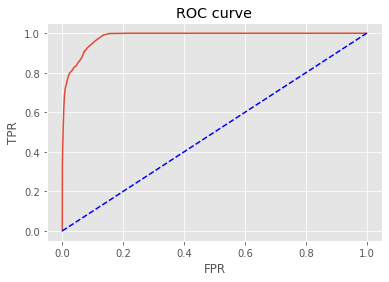

AUC : 0.9819292973295879


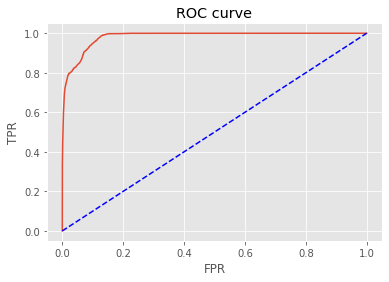

In [113]:
y_train_score = pd.DataFrame(em.predict_proba(em.X_train), index=em.y_train.index, columns=["CompraScore"])
em.get_auc_metrics(em.y_train, y_train_score)
em.get_auc_metrics(em.y_test, y_test_score)

In [109]:
top_features = em.get_feature_importance()

In [110]:
top_features

active_customer    0.311637
cluster            0.216577
Numero_bajas       0.155420
entry_year         0.124165
entry_day          0.068269
age                0.051155
Num_cobros         0.034928
entry_week         0.026255
Numero_altas       0.011595
entry_weekday      0.000000
gender             0.000000
region_code        0.000000
country_id         0.000000
dtype: float32

AUC : 0.9933457907373408


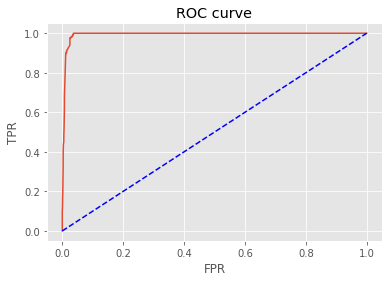

In [111]:
y_val_score = pd.DataFrame(em.predict_proba(em.X_val), index=em.y_val.index, columns=["CompraScore"])
em.get_auc_metrics(em.y_val, y_val_score)

In [ ]:
# comprobamos la capacidad de prediccion del modelo para las ventas de junio

# Save Models

In [ ]:
# no optimizaremos el modelo !

In [ ]:
# bootstrap para los productos de financiacion (en caso de que su modelo tenga mala perfrmance)
# o probar kfold 
# kf = model_selection.KFold(n_splits=10, random_state=RANDOM_STATE, shuffle=False)

In [ ]:
# ejecutar modelos reducidos y guardarlos (solo con las features importantes)

In [ ]:
# TODO meter el beneficio por producto que nos aporta el cliente (una vez tengamos los distintos modelos ya hechos) 
# y hayamos sacado la lista de clientes
# Tendremos que coger los 1666 (10e3 // 6) clientes con mejor scoring de cada modelo 
# o coger más de los que más beneficio nos aporte